## What is classification? 

Some times the data in a supervised learning task is more qualitative than quantitative such as high, medium, low; or the task has categorical outputs such as colors - red, blue, green, or type of fruits: orange or apple. In such cases we look at classification models for training a model predictor. Various types of classification tasks exists: 

### Type of classification: 

#### 1. Binary classifier: 
Distinguish between two classes - high, low, or cat and a dog. A simplest algorithm to train for such a task is logistic regression. Most of the off-the-shelf algorithms work directly on the such tasks -- SVM, Random Forests, Naive Bayes. 

#### 2. Multi-`class` classifier: 
Distinguish between more than two classes - digits classifier is an example of multi-class classification since for a given digit image the answer could any number from 0-9. It is still `one` class but multiple options exists. Certain algorithms like Random Forest, Naive Bayes are capable of handling multi-class classifier. Others like SVM and linear classifiers are strictly binary classifier. 

There are ways you can convert a binary classifier: 
* **One-versus-all:**

Train `n` classifier for `n` classes such that each classifier ONLY predicts whether __that__ class is present or not. Eg: Train a classifier to predict if a digit is 2 or not. 

* **One-versus-one**:

Pair-wise classifier, in this case models are trained in a binary fashion for as many pair there can be between `n` classes. This can become computationally expensive since for `n` classes: $n(n-1)/2$ classifiers are needed. 

Main advantage in this approach is that size of training data is small as only pair-wise data is required. Such an approach is useful when models dont scale well with large data -- such as SVM or gaussian based 

#### 3. Multi-`label` or Multi-output classifier: 
Distinguish between more than class but also the answer is not just one value but a list of possiblities. When the output amongst the list is _only_ Binary it is usually refered to as Multi-`label` classification. For example: 

If we train a model to classify a digit image as: 
    
    1. Is it smaller than 4? (1:yes; 0:no)
    
    2. Is it odd number? (1:yes; 0:no)
    
    3. Is it is greater than 7? (1:yes; 0:no)
    
Then the output would be a list - for 5: [0, 1, 0] ; 4: [0, 0, 0]; 3: [1, 1, 0]

K-Nearest neighbor is a type of classifier which supports such a classification. 

Scikit-learn has a wonderful documentation on metrics to be used for different types of classification tasks [(Link here)](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

From the Scikit-learn documentation: 
```
Some metrics are essentially defined for binary classification tasks (e.g. f1_score, roc_auc_score). In these cases, by default only the positive label is evaluated, assuming by default that the positive class is labelled 1 (though this may be configurable through the pos_label parameter).

In extending a binary metric to multiclass or multilabel problems, the data is treated as a collection of binary problems, one for each class. There are then a number of ways to average binary metric calculations across the set of classes, each of which may be useful in some scenario. Where available, you should select among these using the average parameter.
```

The code in this notebook is adapted from Aurélien Geron's hands-on machine learning tutorial on Classifications [Github Link](https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb)

In [1]:
import os 
import copy
import numpy as np

np.random.seed(42)

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# High DPI rendering for mac
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}


plot_params = {
'font.size' : 22,
'axes.titlesize' : 24,
'axes.labelsize' : 20,
'axes.labelweight' : 'bold',
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,
}

plt.rcParams.update(plot_params)

## MNIST dataset

70,000 small images of hand-written numbers. Each image has 784 features. Those features are split in 28x28 pixels and each feature is simply that pixel gray-scale intensity. Value for each pixel ranges from 0 to 255. 

In [3]:
from sklearn.datasets import load_digits
mnist = load_digits()
print(mnist.data.shape)

(1797, 64)


In [4]:
# Using MNIST data from openML website 
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

In [5]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    
    #minist.data is a pandas DataFrame
    mnist_data_numpy = np.array(mnist.data.values)
    mnist_target_numpy = np.array(mnist.target.values)
    
    mnist_data_numpy[:60000] = mnist_data_numpy[reorder_train]
    mnist_target_numpy[:60000] = mnist_target_numpy[reorder_train]
    mnist_data_numpy[60000:] = mnist_data_numpy[reorder_test + 60000]
    mnist_target_numpy[60000:] = mnist_target_numpy[reorder_test + 60000]
    
    return mnist_data_numpy, mnist_target_numpy

In [7]:
X, y = sort_by_target(mnist)

The 62123 entry is a photo of 2


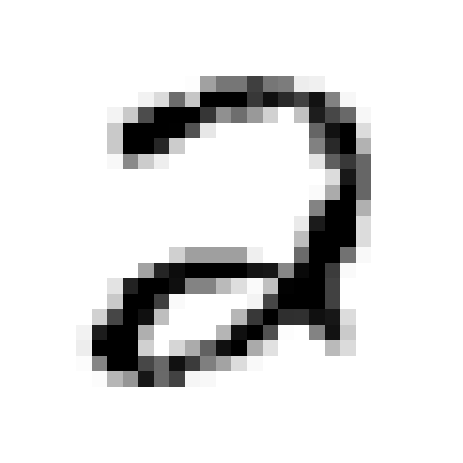

In [8]:
random_idx = 62123

digit_image, digit_label = X[random_idx], y[random_idx]
print('The {0} entry is a photo of {1}'.format(random_idx, digit_label))

random_digit_image=digit_image.reshape(28,28)
plt.imshow(random_digit_image, cmap=cm.binary,
          interpolation="nearest")
plt.axis("off");

In [9]:
#Plot digit convenience function
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before training we shuffle the data to ensure all cross-validation folds to be similar. Moreover some classficiation algorithms are sensitive to the order of training instances, and they perform poorly if they get many similar instances in a row. 

In [11]:
#Index shuffling 
import numpy as np 
index_shuffle = np.random.permutation(60000)
X_train, y_train = X_train[index_shuffle], y_train[index_shuffle]

## Binary classification 

Here we will build a single digit classifier -- for example looking at just 2. Hence in total there will be only 2 classes -- Those which are 2 and those which are not. 

In [16]:
y_train_2 = (y_train == 2) #True for all 2s, False for all other digits 
y_test_2 = (y_test == 2)

Using `Stochastic Gradient Descent` classifier. Known to handle large datasets very well. 

In [17]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_2)

SGDClassifier(max_iter=5, random_state=42, tol=-inf)

In [19]:
sgd_clf.predict([digit_image])

array([ True])

## Performance metrics

Evaluating classifiers is often significantly challenging than the case for a regressor wherein we can use RMSE or MAE. Let's look at some usual metrics used to gauge the classifier performance. 

### 1. Accuracy using Cross-validation

It involves splitting your training data in K-folds. Training the model on K-1 folds and testing it on the left out fold. Scikit learn has in-built method to do so: `cross_val_score()`. We can implement our own version as well. 

$$ \% Accuracy = \frac{Correct}{Total} * 100 $$ 

In [20]:
#Inside the scikit-learn's crossvalidation accuracy method
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3, shuffle=False)

for train_index, test_index in skfolds.split(X_train,y_train_2):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_2[train_index]
    
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_2[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred=clone_clf.predict(X_test_folds)
    
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

0.97365
0.96255
0.96165


In [21]:
#Using scikit-learn's in-built method 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_2, cv=3, scoring='accuracy')

array([0.97365, 0.96255, 0.96165])

Does this high accuracy tell us anything? 

Is the sample space we are looking at uniform enough for this accuracy? 

Maybe we have way less one-digit samples for training in the first place. 

In [26]:
_count=0.
for i in range(len(y_train)):
    if y_train[i] == 2: 
        _count=_count+1.
print(_count/len(y_train)*100)     

9.93


So ~9% of the sample are actually 2. So even if we guess ALWAYS that image is not 2 we will be right 90% of the time!

### The dumb classifier 
To check whether classifier accuracy of ~95% is good enough so just a over-exagerration

In [27]:
from sklearn.base import BaseEstimator
class Never2(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return(np.zeros((len(X),1),dtype=bool))

In [28]:
never2 = Never2()
cross_val_score(never2,X_train,y_train_2,cv=3,scoring='accuracy')

array([0.9017, 0.9001, 0.9003])

This shows our data is skewed! 

### 2. Confusion Matrix

General idea is to count the number of times instances of Class A are classified as Class B. 

Table that describes the performance of a classification model by grouping predictions into 4 categories.
- True Positives: we correctly predicted they do have diabetes
- True Negatives: we correctly predicted they don’t have diabetes
- False Positives: we incorrectly predicted they do have diabetes (Type I error)
- False Negatives: we incorrectly predicted they don’t have diabetes (Type II error)

The ROWS in the matrix are the real class-labels i.e. the TRUTH values while COLUMNS are the predicted values. 

<table class="docutils align-default">
<colgroup>
<col style="width: 29%">
<col style="width: 32%">
<col style="width: 39%">
</colgroup>
<tbody>
<tr class="row-odd"><td></td>
    <td colspan="2"><p><b>Actual class (observation)</b></p></td>
</tr>
<tr class="row-even"><td rowspan="2"><p><b>Predicted class
    (expectation)</b></p></td>
<td><p>tp (true positive)
Correct result</p></td>
<td><p>fp (false positive)
Unexpected result</p></td>
</tr>
<tr class="row-odd"><td><p>fn (false negative)
Missing result</p></td>
<td><p>tn (true negative)
Correct absence of result</p></td>
</tr>
</tbody>
</table>

In [29]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3)

In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_2, y_train_pred)

array([[53159,   883],
       [ 1160,  4798]])

Each row in the confusion matrix represent `actual class`, while each column represents a `predicted class`. Following are the terms of the confusion matrix: 
1. First row of this matrix is the non-2 images -- 
    - (0,0) instances were correctly classified as non 2 (True Negative)
    - (0,1) instances were wrongly classified as 2s (False Positive)
2. Second row considers the images of 5 -- 
    - (1,0) instances were wrongly classified as non 2s (False negatives) 
    - (1,1) instances were correctly classified as 2s (True positives)
    
An ideal classifier would be a diagonal matrix with no false positives or false negatives

#### Precision 

Think of this as precision of the model in estimating the binary class. FROM POV of the MODEL

It is the ratio of the total classification whether as `True` or `Wrongly classified as True` to `True`. That is, 
$$Precision = \frac{TP}{TP+FP}$$ 

This is looking at +ve classification and how many are really +ve and how many are wrongly shown as +ve. So Precision looks at the prediction of +ve results. 

#### Recall 

Think of this as comparing to the actual data in the model training. FROM POV of the REAL DATA 

It is the ratio of total classification on the +ve samples from where they are classified correctly (TP) to wrongly classified as negative (FN). 

$$Recall = \frac{TP}{FN+TP}$$

So Recall looks at the prediction of the +ve samples. 

> This is by just comparing the +ve samples in the binary classification. To check how many of them are correctly recalled as +ve. 

#### F1 score

Harmonic mean of recall and precision. Higher the Precision and Recall, lower are the instances of FP and FN. So we want to have higher Recall and Precision both.  

F1 favors classifiers with similar recall and precision. 

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision score: {}'.format(precision_score(y_train_2, y_train_pred)))
print('Recall score: {}'.format(recall_score(y_train_2, y_train_pred)))
print('F1 score: {}'.format(f1_score(y_train_2, y_train_pred)))

Precision score: 0.8445696180249956
Recall score: 0.8053037932192011
F1 score: 0.8244694561388435


### Recall/Precision tradeoff

Unfortunately increasing precision reduces recall and vise-versa. However sometimes one of the qualities could be desirable in a model. 

Recall looks at lowering the `False Negatives` so culling +ve cases. That could be detrimental in catching robberies. So we need classifiers with high recall and we are okay with low `Precision` wherein we would get **False alarms**.

Meanwhile, if we are censoring videos we need high `Precision` to ensure unsafe videos categorised as Safe ones. While we could be removing good videos by wrongly classifying them to be Unsafe (low recall). 

More discussion here: [Link](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)

Decision functions evaluate a `decision_score` we can manually set the `threshold` for the score to whether that will accpted or rejected for the binary case. 

**Increasing threshold reduces recall, but increases precision.**

Why? 
The more `Precise` you want to be i.e. more True Positive than False Positives -- the higher the threshold for passing the case of accepting the data as a given class. However doing so we are strict in what we define as a ideal class and can neglect samples which are positive but are not closest to ideal. Hence we do incorrectly mark them as Negative thus increasing the case of False Negaitives and hence lowering `Recall`. 

In [32]:
#Decision scores for all instnces in the training set -- 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3,
                             method="decision_function")

In [33]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_2, y_scores)

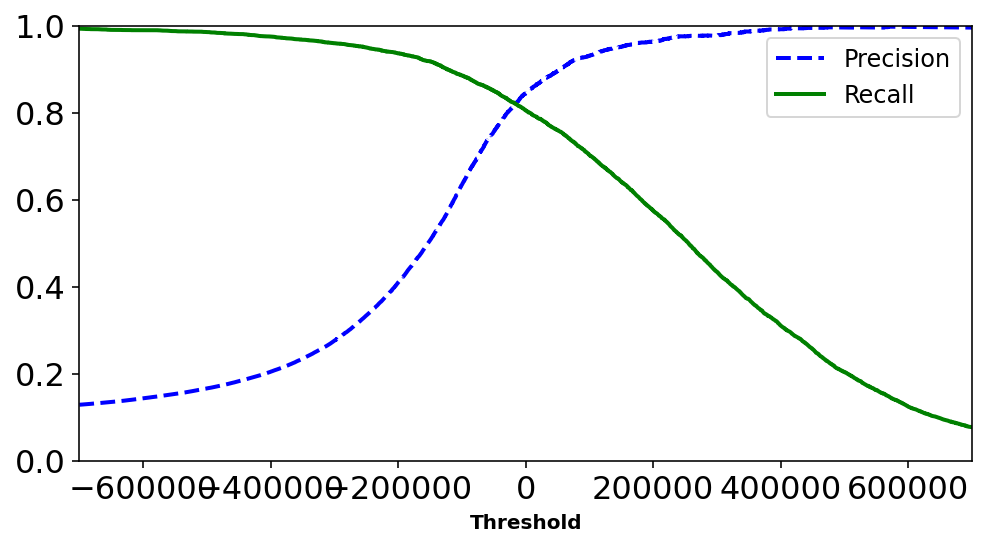

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=10)
    plt.legend(loc="best", fontsize=12)
    
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

Text(0.5, 0, 'Recall')

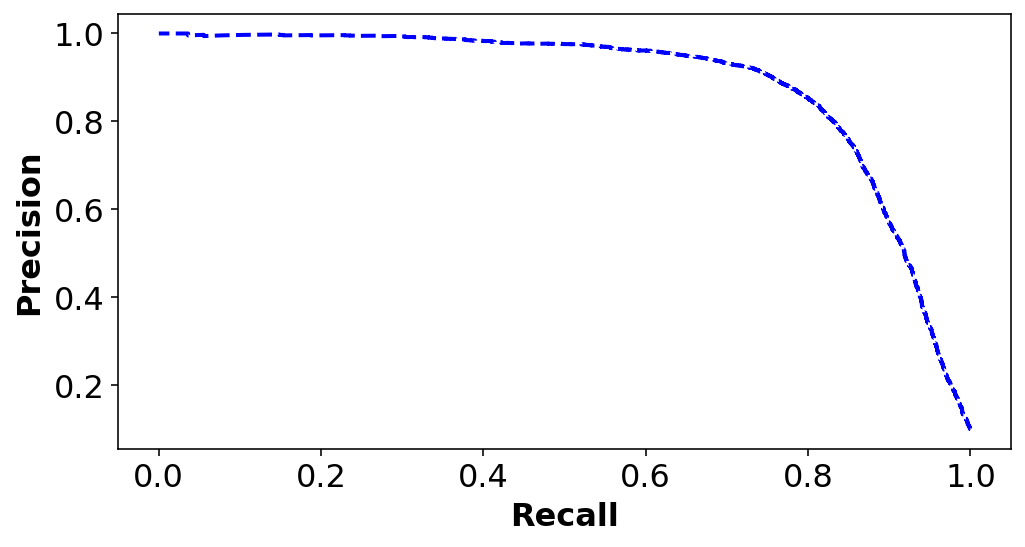

In [36]:
plt.figure(figsize=(8, 4))    
plt.plot(recalls[:-1],precisions[:-1], "b--", label="Precision", linewidth=2)
plt.ylabel("Precision", fontsize=16)
plt.xlabel("Recall", fontsize=16)

>If someone says let's reach 99% PRECISION, we must ALWAYS ask at what RECALL? 

#### Manually set the Recall/Precision using threshold

In [39]:
y_scores = sgd_clf.decision_function([digit_image])
print(y_scores)

y_pred_thresh = sgd_clf.predict([digit_image])
print(y_pred_thresh)
#Setting threshold higher than the y_score
threshold = y_scores + 1.0 
y_pred_thresh = (y_scores > threshold)
print(y_pred_thresh)

[247991.40436599]
[ True]
[False]


In [40]:
#Changing the threshold for everyother training example -- more than 90% precision
y_scores = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3,
                             method="decision_function")
y_train_pred_90 = (y_scores > 200000)
print('Precision score: {}'.format(precision_score(y_train_2, y_train_pred_90)))
print('Recall score: {}'.format(recall_score(y_train_2, y_train_pred_90)))
print('F1 score: {}'.format(f1_score(y_train_2, y_train_pred_90)))

Precision score: 0.9637028700056275
Recall score: 0.5748573346760658
F1 score: 0.720142977291842


We have made classifier with an arbitrary Precision score: 97% However doing so we reduced the Recall. 

### The ROC curve

Another common tool used for binary classifiers apart from Precision/Recall. Instead of plotting precision vs recall we plot `True Positive Rate` (TPR) i.e. `Recall` against `False Positive Rate` (FPR). FPR is the ratio of negative instances that are incorrectly classified as positive. 

ROC plots sensitivity vs `1-specificty` 

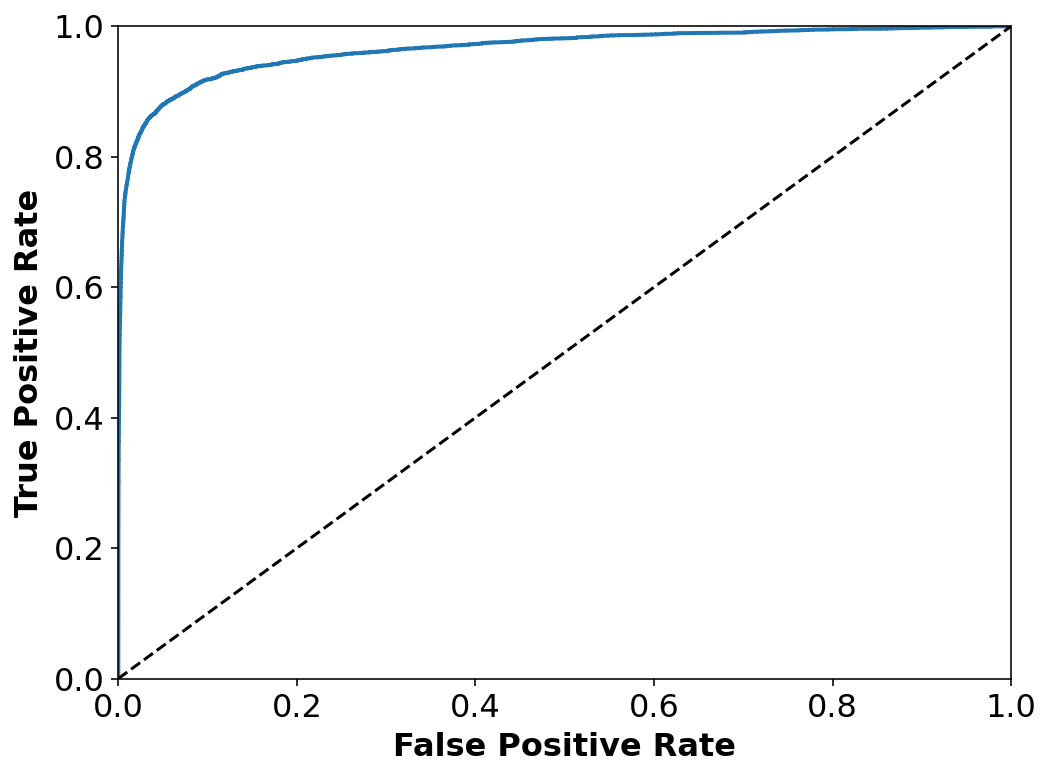

In [41]:
from sklearn.metrics import roc_curve

#Decision scores for all instnces in the training set -- 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3,
                             method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train_2, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_2, y_scores)

0.9651158581307573

PR curve when we care of precision -- getting False +ve and not so much of getting False -ve. We are okay with losing some +ve cases but for sure do not want to neglect any -ve ones. 

## Random forest classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_2, cv=3,
                                    method="predict_proba")

In [44]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_2, y_scores_forest)

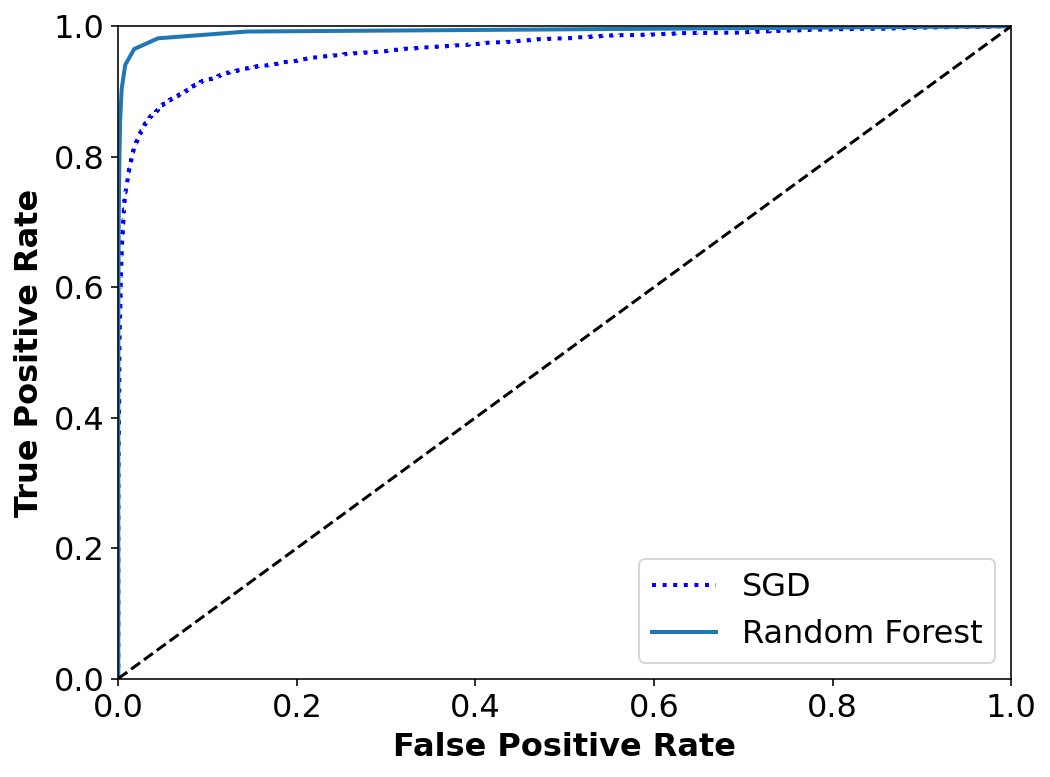

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

## Multiclass classification 

Multiclass classifiers are able to label and distinguish between more than two classes. Some algorithms such as Random Forest and Näive Bayes are capable of handling this directly. Having said that, Naive Baye's has shortcomming of considering class conditional independence and having discrete entries in the input. 

- OvA (One-versus-all classifiers): Herein, we would train n binary classifiers for n type of labels and see which n-th classifier has highest decision score. 

- OvO (One-versus-one strategy): Binary classifier for every pair. So for n labels we will have n(n-1)/2 classifiers. 

## Error analysis

In [46]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
index_shuffle = np.random.permutation(60000)
X_train, y_train = X_train[index_shuffle], y_train[index_shuffle]

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train)

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3,
                             method="decision_function")
conf_mx = confusion_matrix(y_train, y_train_pred)

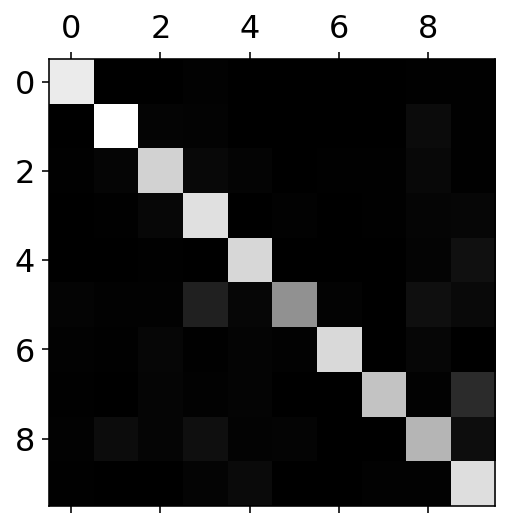

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

## Plotting heat-map for the errors in the classification

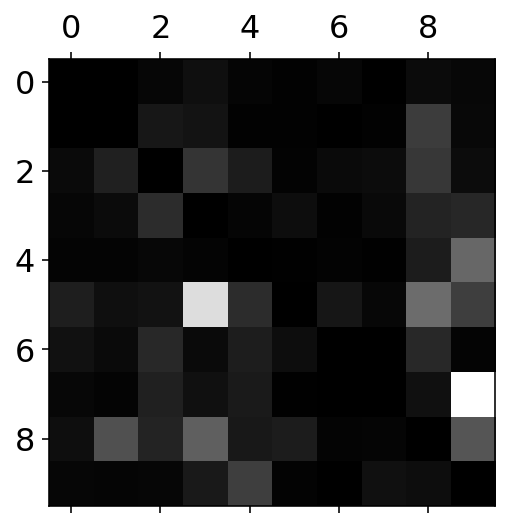

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
#Diagonals are filled to be zero to concentrate only at the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

`ROWS` in the confusion matrix are the REAL labels. `COLUMNS` in the confusion matrix are the PREDICTED values. It can seen that in the case of row 3 and column 5: 
- 5 is most of the times confused with 3 and 8
- 9 is confused with 4 and 7 

In [49]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = cm.binary, **options)
    plt.axis("off")

In [50]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

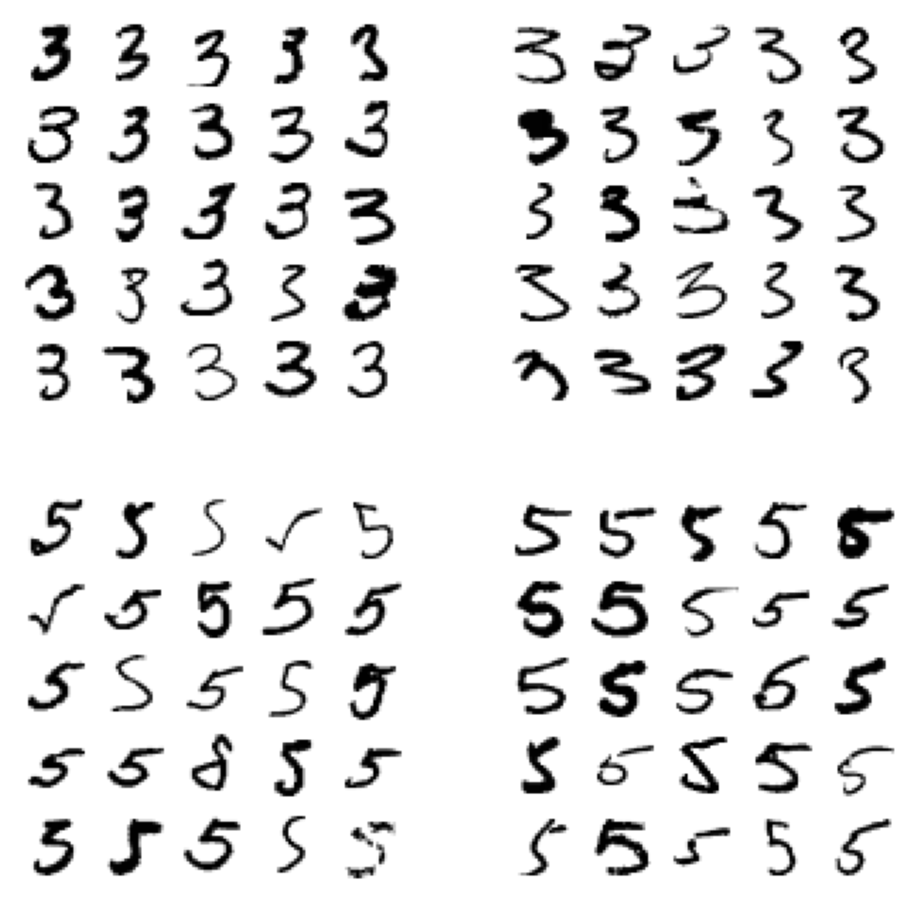

In [51]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Given above are two sets of '3' and '5' -- the boxes to the left are 3 and 5 classified as 3. Top left are the images of 3 classified as 3 while Bottom left are the images of 5 classified as 3. It can seen that some imags of 5 quite poor and the algorithm (which is linear in this case) will have difficulty predicting it. 

## Multi-label classifier 

Determine a label such that it is a list for a every digit answering two questions: 
1. Is this number odd? 1: Yes, 0: No
2. Is this number greater than 7? 1: Yes, 0: No

Creating new y_label for model 

In [93]:
# Setting two conditions 
is_odd = (y % 2 == 0).astype(int)
is_greater_7 = (y > 7).astype(int)

y_multilabel = np.c_[is_odd, is_greater_7]

In [94]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

In [95]:
X_train, X_test, y_ml_train, y_ml_test = X[:60000], X[60000:], y_multilabel[:60000], y_multilabel[60000:]
index_shuffle = np.random.permutation(60000)
X_train, y_ml_train = X_train[index_shuffle], y_ml_train[index_shuffle]

In [96]:
knn_clf.fit(X_train, y_ml_train)

KNeighborsClassifier()

In [97]:
# Predict
knn_clf.predict([X_train[12]])

array([[0, 0]])

In [98]:
y_ml_train[12]

array([0, 0])

In [99]:
# Metric 
y_knn_ml_pred= cross_val_predict(knn_clf, X_train, y_ml_train, cv=3)

In [100]:
# macro assumes all labels are equally important 
# another option is the 'weighted' 
f1_score(y_ml_train, y_knn_ml_pred, average='macro')

0.9719059410724892